In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import argparse
from astropy.io import ascii
from astropy.table import Table
from foggie.utils.foggie_utils import filter_particles
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.consistency import *
from foggie.utils import yt_fields
import foggie.utils.prep_dataframe as prep_dataframe 
import yt
from foggie.render import shade_maps as sm
import foggie.render.cmap_utils as cmaps

import matplotlib.image as mpimg

In [109]:
halo = '8508'
output = 'DD0487'
ds_loc = '/Users/rsimons/Desktop/foggie/sims/halo_008508/nref11c_nref9f/DD0487/DD0487'
trackname = '/Users/rsimons/Dropbox/git/foggie/foggie/halo_tracks/008508/nref11n_selfshield_15/halo_track_200kpc_nref9'

ds = yt.load(ds_loc)
def _velocity1d(field, data):
    bulk_velocity = data.get_field_parameter('bulk_velocity')
    return np.sqrt((data['gas', 'velocity_x'] - bulk_velocity[0])**2. + (data['gas', 'velocity_y'] - bulk_velocity[1])**2. + (data['gas', 'velocity_z'] -  - bulk_velocity[2])**2.)/(sqrt(3))
ds.add_field(("gas", "velocity_1d"), function=_velocity1d, units="km/s")

def _static_radial_rampressure(field, data):
    vel = data['gas', 'velocity_1d']
    rp = data['density'] * vel**2.
    return np.log10(rp.to('dyne/cm**2'))


ds.add_field(("gas", "ram_pressure"), function=_static_radial_rampressure, units = "")


track = Table.read(trackname, format='ascii')
track.sort('col1')
zsnap = ds.get_parameter('CosmologyCurrentRedshift')

refine_box, refine_box_center, x_width = get_refine_box(ds, zsnap, track)
filter_particles(refine_box)
bulk_velocity = refine_box.quantities.bulk_velocity()
refine_box.set_field_parameter('bulk_velocity', bulk_velocity)
sat_cat = ascii.read('/Users/rsimons/Dropbox/foggie/catalogs/satellite_properties.cat')

sat_cat = sat_cat[sat_cat['halo'] == int(halo)]

for sat in sat_cat:
    x, y, z = sat['x'], sat['y'], sat['z']
    sat_center = ds.arr([x,y,z], 'kpc')
    from yt.units import kpc
    small_sp = ds.sphere(sat_center, 10 * kpc)
    refine_box -= small_sp


yt : [INFO     ] 2019-12-05 16:46:57,955 Parameters: current_time              = 154.8165043678
yt : [INFO     ] 2019-12-05 16:46:57,956 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2019-12-05 16:46:57,956 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2019-12-05 16:46:57,957 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2019-12-05 16:46:57,957 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2019-12-05 16:46:57,958 Parameters: current_redshift          = 1.9997938414155
yt : [INFO     ] 2019-12-05 16:46:57,958 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2019-12-05 16:46:57,959 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2019-12-05 16:46:57,959 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 7623/7623 [00:00<00:00, 64507.18it/s]
yt : [INFO     ] 2019-12-05 16:46:58,252 Gathering a field list (this may take a moment.)
/Users/rsimons/mini

get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.99979384142 0.493035 0.487894 0.501194 0.495035 0.489894 0.503194    9
filtering stars particles...
filtering dm particles...


In [110]:
rb_velocity    = refine_box['gas', 'velocity_1d'].to('km/s')
rb_density     = refine_box['gas', 'density'].to('g*cm**-3')
rb_volume      = refine_box['index', 'cell_volume'].to('kpc**3')

/Users/rsimons/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


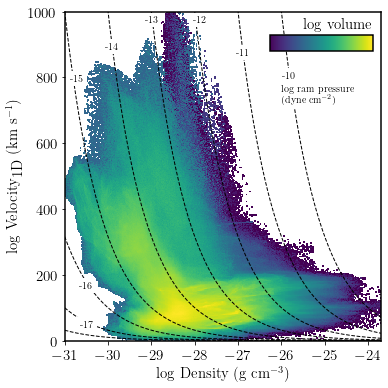

In [165]:
fig, ax = plt.subplots(1,1,figsize = (5.5,5.5))

use_lvel = False

if use_lvel:
    min_lvel = 0
    max_lvel = 3.1
    vel_plot = np.log10(rb_velocity)
else:
    min_lvel = 0
    max_lvel = 1000
    vel_plot = rb_velocity

    
    

min_ldens = -31
max_ldens = -23.7


im = ax.hist2d(log10(rb_density), vel_plot, weights = rb_volume, norm = matplotlib.colors.LogNorm(), bins = 500)
rp_densities = yt.YTArray(10**np.linspace(min_ldens, max_ldens, 1000), 'g*cm**-3')
ram_pressures = yt.YTArray(10.**np.arange(-18, -9, 1), 'dyne*cm**-2')

cbaxes = fig.add_axes([0.69, 0.86, 0.26, 0.04]) 
cbar = fig.colorbar(im[3], ax = ax, cax = cbaxes, orientation = 'horizontal')
cbar.set_ticks([])
#cbar.minorticks_off()

#cbar.ax.tick_params(size=0)
#cbar.set_ticklabels([''])

cbaxes.annotate('$\log$ volume', (1.0, 1.7), xycoords = 'axes fraction', ha = 'right', va = 'center', color = 'black', fontsize = 15)


bbox_props = dict(boxstyle="Square, pad = 0.3", fc="white", ec=None, lw=0)
vspots = np.array([820, 890, 988, 988, 908, 810, 180, 62,  nan])[::-1]
for r, ram_pressure in enumerate(ram_pressures):
    
    rp_velocities = (np.sqrt(ram_pressure/rp_densities)).to('km/s')
    
    if use_lvel: rp_velocities = np.log10(rp_velocities)
    mid_v = min_lvel + (0.95 - r*0.02) * (max_lvel - min_lvel)

    gd = np.argmin(abs(rp_velocities.value - max_lvel))
    

    if (np.log10(ram_pressure) > -18):# &  (r%2 == 0):
        #ax.annotate("%i"%np.log10(ram_pressure), (np.log10(rp_densities[gd]), rp_velocities[gd]), \
        #            ha = 'left', va = 'center', color = 'black',\
        #           bbox=bbox_props)
    

        gd = np.argmin(abs(rp_velocities.value - vspots[r]))


        if (int(np.log10(ram_pressure)) == -15) | (int(np.log10(ram_pressure)) == -17) | (int(np.log10(ram_pressure)) == -12):
            ax.annotate("%i"%np.log10(ram_pressure), (np.log10(rp_densities[gd]) + 0.1, vspots[r]), \
            ha = 'center', va = 'top', color = 'black', bbox = bbox_props)
        else:
            ax.annotate("%i"%np.log10(ram_pressure), (np.log10(rp_densities[gd]), vspots[r]), \
            ha = 'center', va = 'top', color = 'black', bbox = bbox_props)


    ax.annotate("$\log$ ram pressure\n(dyne cm$^{-2}$)", (-26, 780), \
            ha = 'left', va = 'top', color = 'black', rotation = 0, bbox = bbox_props)

    ax.plot(np.log10(rp_densities), rp_velocities, color = 'black', linestyle = '--', linewidth = 1.0,  alpha = 1.0)


ax.set_xlim(min_ldens, max_ldens)
ax.set_ylim(min_lvel, max_lvel)

ax.set_xlabel('$\log$ Density (g cm$^{-3}$)', fontsize = 15)
ax.set_ylabel(r'$Velocity$_{\textrm{1D}}$ (km s$^{-1}$)', fontsize = 15)


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(15)

fig.tight_layout()
fig.savefig('/Users/rsimons/Dropbox/foggie/figures/for_paper/tempest_2Ddistributions.png', dpi = 300)








In [133]:
field1 = 'radius'
field2 = 'ram_pressure'
colorcode = 'phase'
ranges = ((10,80),(-17,-9))
outfile = '/Users/rsimons/Dropbox/foggie/figures/for_paper/shademap_RP'
pixspread = 0


In [125]:
data_frame = prep_dataframe.prep_dataframe(ds, refine_box, [field1, field2], colorcode, \
                                          halo_center = refine_box_center)

you have requested fields  ['radius', 'ram_pressure']
will have to recompute the radius, halo_center =  [0.494035, 0.488894, 0.502194]
Did not find field = ram_pressure in the dataframe, will add it.
Added phase category to the dataframe


render_image: will spread shaded image by  0  pixels.


/Users/rsimons/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


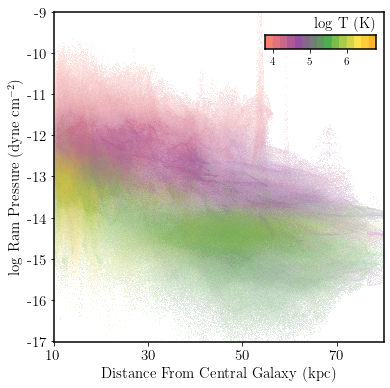

In [188]:
def wrap_axes(dataset, img, filename, field1, field2, colorcode, ranges, region, filter):

    img = mpimg.imread(filename+'.png')
    fig, ax1 = plt.subplots(1,1,figsize = (5.5,5.5))
    plt.rcParams['image.origin'] = 'lower'
    ax1.imshow(np.flip(img,0)) 

    
    xstep = 1
    x_max = ranges[0][1]
    x_min = ranges[0][0]
    if (x_max > 30.): xstep = 20
    if (x_max > 100.): xstep = 100
    ax1.set_xlabel('Distance From Central Galaxy (kpc)', fontsize = 15)#axes_label_dict[field1], fontsize=30)
    ax1.set_xticks(np.arange((x_max - x_min) + 1., step=xstep) * 1000. / (x_max - x_min))
    ax1.set_xticklabels([ str(int(s)) for s in \
        np.arange((x_max - x_min) + 1., step=xstep) +  x_min ])#), fontsize=22)

    ystep = 1
    y_max = ranges[1][1]
    y_min = ranges[1][0]
    if (y_max > 30.): ystep = 10
    if (y_max > 100.): ystep = 100
    ax1.set_ylabel("$\log$ Ram Pressure (dyne cm$^{-2}$)", fontsize=30)
    ax1.set_yticks(np.arange((y_max - y_min) + 1., step=ystep) * 1000. / (y_max - y_min))
    ax1.set_yticklabels([ str(int(s)) for s in \
        np.arange((y_max - y_min) + 1., step=ystep) + y_min])#, fontsize=22)

    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
                ax1.get_xticklabels() + ax1.get_yticklabels()):
                item.set_fontsize(15)

    x0,x1 = ax1.get_xlim()
    y0,y1 = ax1.get_ylim()
    ax1.set_aspect(abs(x1-x0)/abs(y1-y0))

    #ax2 = fig.add_axes([0.7, 0.93, 0.25, 0.06])
    ax2 = fig.add_axes([0.672, 0.852, 0.28, 0.062]) 

    phase_cmap, metal_cmap = cmaps.create_foggie_cmap()
    ax2.imshow(np.flip(phase_cmap.to_pil(), 1))
    ax2.set_xticks([50,300,550])
    ax2.set_xticklabels(['4','5','6',' '],fontsize=11)
    #ax2.text(230, 120, 'log T [K]',fontsize=13)
    ax2.annotate('$\log$ T (K)', (1.0, 1.7), xycoords = 'axes fraction', ha = 'right', va = 'center', color = 'black', fontsize = 15)
    ax2.set_yticklabels([])
    ax2.set_yticks([])

    fig.tight_layout()
    #fig.subplots_adjust(left = 0.15, right = 1.0)
    plt.savefig(filename, dpi = 300)

    return fig
image = sm.render_image(data_frame, field1, field2, colorcode, *ranges, outfile, pixspread=pixspread)
im = wrap_axes(ds, image, outfile, field1, field2, colorcode, ranges,\
               region = 'trackbox', filter ="obj['temperature'] < 1e9")


In [189]:
import PIL
import numpy as np
from PIL import Image
import glob

outfile0 = '/Users/rsimons/Dropbox/foggie/figures/for_paper/Tempest_2Ddistributions.png'
outfile1 = '/Users/rsimons/Dropbox/foggie/figures/for_paper/shademap_RP.png'
fls = [outfile0, outfile1]
imgs = [PIL.Image.open(fl) for fl in fls]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save('/Users/rsimons/Dropbox/foggie/figures/for_paper/distributions_combined.png')    



/Users/rsimons/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


In [92]:
ax.add_

In [30]:
rb_density

YTArray([2.66833911e-27, 1.87451249e-27, 1.31492291e-27, ...,
         3.33659258e-29, 3.31618918e-29, 3.30739208e-29]) g/cm**3

In [40]:
ax.hist2d?